<br />

### Problem 9.2: Outliers in FRET binding curve, 20 pts

We often want to ascertain how tightly two proteins are bound by measuring their dissociation constant, $K_d$.  This is usually done by doing a titration experiment and then performing a regression.  For example, imagine two proteins, a and b may bind to each other in the reaction

\begin{align}
\text{ab} \rightleftharpoons \text{a} + \text{b}
\end{align}

with dissociation constant $K_d$.  At equilibrium

\begin{align}
K_d = \frac{c_a\,c_b}{c_{ab}},
\end{align}

were $c_i$ is the concentration of species $i$.  If we add known amounts of a and b to a solution such that the total concentration of a is $c_a^0$ and the total concentration of b is $c_b^0$, we can compute the equilibrium concentrations of all species.  Specifically, in addition to the equation above, we have conservation of mass equations,

\begin{align}
c_a^0 &= c_a + c_{ab}\\[1em]
c_b^0 &= c_b + c_{ab},
\end{align}

fully specifying the problem.  We can solve the three equations for $c_{ab}$ in terms of the known quantities $c_a^0$ and $c_b^0$, along with the parameter we are trying to measure, $K_d$.  We get

\begin{align}
c_{ab} = \frac{2c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The technique, then, is to hold $c_a^0$ fixed in the experiment and measure $c_{ab}$ for various $c_b^0$. We can then perform a regression to get $K_d$.

In order to do this, though, we need some readout of $c_{ab}$. For this problem, we will use FRET (fluorescence resonance energy transfer) to monitor how much of a is bound to b.  Specifically, we consider a to have a fluorophore and b to be its receptor.  When the two are unbound, we get a fluorescence signal per molecule of $f_0$.  When they are bound, the receptor absorbs the light coming out of the fluorophore, so we get less fluorescence per molecule, which we will call $f_q$ (for "quenched").  Let $f$ be the total per-fluorophore fluorescence signal.  Then, the measured fluorescence signal, $F$, is

\begin{align}
F = c_a^0\,V f = \left(c_a \,f_0 + c_{ab}\, f_q\right)V,
\end{align}

where $V$ is the reaction volume. We can absorb $V$ into the other parameters such that $\hat{f}_0 = f_0 V$ and $\hat{f}_q = f_q V$, giving

\begin{align}
F = \hat{f}_0(c_a^0 - c_{ab}) + \hat{f}_q\, c_{ab}
= \hat{f}_0\,c_a^0 - \frac{2(\hat{f}_0 - \hat{f}_q)c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

Compute parameter estimates for $K_d$ with and without an outlier detection scheme for [this data set](../data/fret_binding_curve.csv). How do the results differ depending on whether or not you were trying to detect outliers?

*Note*: These are real data, but they are from an unpublished experiment here on campus. I therefore have not exposed the identities of the proteins a and b.

In [1]:
import glob
import os
import sys

import numpy as np
import pandas as pd
import scipy.signal

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Pevent bulky altair plots
alt.data_transformers.enable('json')

import bebi103
import bokeh
from bokeh.palettes import all_palettes
import itertools
from bokeh.models import Legend, LegendItem
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
df = pd.read_csv("../data/fret_binding_curve.csv", comment = '#')
df

,buffer,fluorescence,a conc (nM),b conc (nM)
0,1256.5751,258316.2818,50.0,1500.000000
1,1256.5751,267722.6277,50.0,750.000000
2,1256.5751,267431.6620,50.0,375.000000
3,1256.5751,284596.2914,50.0,187.500000
4,1256.5751,254903.3958,50.0,93.750000
5,1256.5751,333810.6371,50.0,46.875000
6,1256.5751,370821.7778,50.0,23.437500
7,1256.5751,408856.1424,50.0,11.718750
8,1256.5751,431000.0000,50.0,5.859375
9,1256.5751,437000.0000,50.0,0.000000


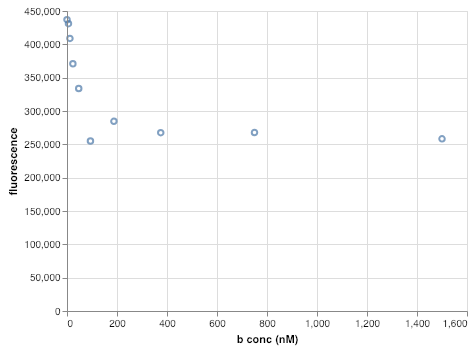

In [3]:
alt.Chart(df).mark_point().encode(
    x = alt.X("b conc (nM)"),
    y = alt.Y("fluorescence"))

LOL I wonder if there are any outliers

Given our known quantities and our goal, the relevant equation is:
\begin{align}
F
= \hat{f}_0\,c_a^0 - \frac{2(\hat{f}_0 - \hat{f}_q)c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The concentration of a is a set quantity in this experiment and that of b is our independent variabl, so we need parameter estimates of $K_d$, $\hat{f}_0$, and $\hat{f}_q$. Additionally we want to include a Gaussian error term $\sigma$ to reflect errors in measurement. Our priors are as follows:

$$\text{fl} = \text{Norm}(F(c_a^0), \sigma).$$ 

In [4]:
data = dict(N=len(df),
           cb=df['b conc (nM)'].values.astype(float))

$K_d$ ~ gamma(1.1, 1) Given our (limited) knowledge of dissociation constants, we expect $K_d$ to be very small, but do no know the order of magnitude, so we will use a log-normal distribution

$\hat{f}_0$ ~ Norm(10000, 1000) Flourescence is an ununited relative value, but in this experiment it appears to be between 100000 and 500000. Since $F= \hat{f}_0\,c_a^0$, we expect the highest fluorescence value to be $50*\hat{f}_0$ so we will choose a distribution with a wide variation at the top of this scale

$\hat{f}_q$ ~ Norm(1000,100) We expect quenched molecules to have a much smaller fluorescence than the unquenched molecules, so we will choose a distribution an order of magnitude smaller than that of $\hat{f}_0$

$\sigma$ ~ Half-Norm(0, .5): We expect a variability in measurement of about .1, and to vary from that by about .1. 

Additionally, we know that 
$c_a^0$ = 50 nM

In [5]:
sm = bebi103.stan.StanModel(file='./9.2_prior.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4962812ee9de1a2e4d0f859578ca95cf NOW.
/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/w3/tn6brvj12bx95d_v766ht54h0000gn/T/tmp205hkza6/stanfit4anon_model_4962812ee9de1a2e4d0f859578ca95cf_8907887455967360052.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [6]:
samples = sm.sampling(data=data, algorithm="Fixed_param",
                          warmup=0,
                          chains=1,
                          iter=1000)

/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [7]:
df_gen = bebi103.stan.to_dataframe(samples, diagnostics=False)

In [8]:
cols = ["fl[1]", "fl[2]", "fl[3]", "fl[4]", "fl[5]",
        "fl[6]", "fl[7]", "fl[8]", "fl[9]", "fl[10]"]

In [9]:
df_gen_fl = df_gen[cols]
df_gen_fl = df_gen_fl.stack(level=0)
df_gen_fl = df_gen_fl.reset_index()
df_gen_fl = df_gen_fl.sort_index(level=1)


# Renaming the columns with useful names
df_gen_fl = df_gen_fl.rename(columns={'level_0': 'model', 
                                  'level_1': 'cb',
                                  0:'fluorescence signal'})

# Renaming the conditions with more descriptive names
for i in range(len(cols)):
    df_gen_fl = df_gen_fl.replace({cols[i]:data['cb'][i]})
    



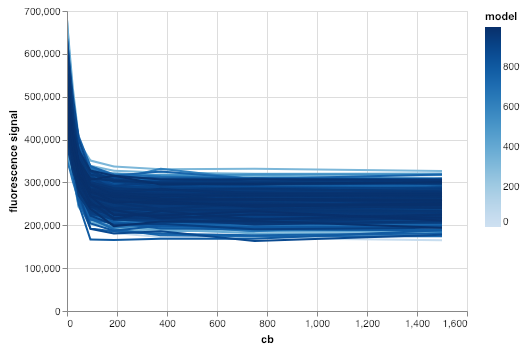

In [10]:
alt.Chart(df_gen_fl).mark_line().encode(
    x = alt.X('cb'),
    y = alt.Y('fluorescence signal'),
    color = alt.Color('model')).interactive()
    

In [121]:
sm2 = bebi103.stan.StanModel(file='./9.2_model.stan')

Using cached StanModel.


In [122]:
data = dict(N=len(df),
           cb=df['b conc (nM)'].values.astype(float),
           fl=df['fluorescence'].values.astype(float))

In [123]:
samples2 = sm2.sampling(data=data, 
                       control=dict(adapt_delta = .99999999,
                                    max_treedepth = 12),
                       warmup=2000, 
                       iter=3000, 
                       thin=5)
bebi103.stan.check_all_diagnostics(samples2)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
45.0 of 800 (5.625%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 800 (0.0%) iterations saturated the maximum tree depth of 12.
E-BFMI indicated no pathological behavior.


4

In [124]:
df2 = bebi103.stan.to_dataframe(samples2, diagnostics=False, inc_warmup=False)

In [125]:
df2.tail()

,chain,chain_idx,warmup,Kd,f0,fq,sigma_g,F[1],F[2],F[3],...,fl_ppc[2],fl_ppc[3],fl_ppc[4],fl_ppc[5],fl_ppc[6],fl_ppc[7],fl_ppc[8],fl_ppc[9],fl_ppc[10],lp__
795,4,196,0,2.265996,8725.441458,4608.916210,17533.403236,237376.139905,243854.972460,255623.837237,...,235121.861639,265797.330197,275775.465092,303447.787063,326809.412692,361692.524216,386405.481753,427349.845622,424620.317069,-103.217945
796,4,197,0,2.876194,8945.454513,4633.422259,14625.406565,239012.453244,245870.304158,258314.784109,...,255047.501062,268544.910945,242645.069619,303845.878843,354271.833151,378757.595918,414025.278834,422037.650772,473589.488293,-103.338608
797,4,198,0,0.707075,8856.762274,4821.336574,15826.020964,247664.613543,253844.574711,265100.330220,...,274260.477696,251875.421584,287042.776456,284719.951059,344683.266793,392657.002808,405641.592587,415046.507860,444636.751045,-101.601057
798,4,199,0,2.025698,8595.579890,4870.508384,17050.017336,249768.854691,255607.291802,266217.197100,...,302451.677734,258445.016662,308182.674573,327233.619955,352095.564104,375668.792459,392468.385213,424496.464803,426980.478261,-102.642452
799,4,200,0,1.803381,8667.583421,4732.832514,15972.841272,243209.255420,249352.559897,260520.700874,...,242009.700382,271355.072888,253454.811139,310336.331474,339156.791298,374678.512506,402618.562159,413115.435770,439128.050396,-101.944881


In [126]:
parameters = (['Kd', 'f0', 'fq','sigma_g'] 
            + ['lp__'])
def plot_parallel_coordinate(samples, parameters):
    samples_dataframe = bebi103.stan.to_dataframe(samples)
    # Which parametets to use in parallel coordinate plot
    pars = (parameters)

    # Transformations to get them all on the same scale
    transformation = (  [lambda x: x / 10, None, None] 
                      + [lambda x: x / 10]*(len(pars)-4)
                      + [lambda x: x / np.abs(x).max()])

    bokeh.io.show(bebi103.viz.parcoord_plot(samples,
                                            pars=pars,
                                            transformation=transformation,
                                            xtick_label_orientation='vertical'))
    
plot_parallel_coordinate(samples2, parameters)

In [127]:
bokeh.io.show(bebi103.viz.corner(samples2,
                                        pars=['Kd', 'f0', 'fq','sigma_g']))

In [128]:
bokeh.io.show(
    bebi103.viz.predictive_ecdf(samples2,
                                name='fl_ppc', 
                                data=df["fluorescence"]))

In [129]:
# First let's make a helper plotting function
def make_ecdf(dataframe, data):
    c = altcat.catplot(data=dataframe,
               mark='line',
               encoding=dict(x=alt.X(data,
                                     scale=alt.Scale(
                                           clamp=True))),
               transform='ecdf'
              ).properties(height=300,
                           width=300).interactive()
    return c

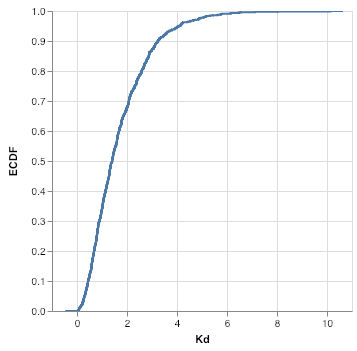

In [130]:
make_ecdf(df2, "Kd:Q")

In [131]:
Kd = df2["Kd"].mean() 
Kd

1.6952757627373993